## Overview

This project focuses on K-means clustering. This algorithm is described in K-Means Section in Chapter 9 of Aurélien Géron's book (main textbook) and Section 3.4 of Daume's book (optional textbook), with an improved version and some theoretical results given in Section 15.1.

We are given vectors in a high-dimensional space. Our goal is to identify k cluster centers and an assignment of vectors, one to each cluster, that minimizes the sum of distance from the vectors to their corresponding cluster centers.

We illustrate this using an important application of clustering to vector quantization.  We will experiment with this in the context of images.  An image consists of pixels.  Each pixel has a red, green and blue value, which are typically represented with 8 bit unsigned integers.  This means every color has a value between 0 and 255.  If we represent these values explicitly, we need 24 bits for every pixel in the image.  If our image has N pixels, we need 24N bits.

But suppose our image only contained 256 distinct colors.  In that case, we could represent the image with much less space.  We would just need a table of 256 colors.  Then, for every pixel we could describe its color with an index into this table.  Representing such a table requires 256x24 bits, while representing the indices requires 8N bits.  Since N is typically very large (megapixel cameras are ubiquitous), we would reduce the size of our image by about a factor of 3.

But real images don't have 256 different colors, they may have millions of different colors.  But many of these colors are pretty similar, so we can often approximate an image with a small number of colors.  We want to do this with as little distortion of the true colors as possible.  K-means is perfect for this.  The cluster centers will be the colors we put in the table.  The assignment of pixels to cluster centers will tell us what color to use in the approximate image for each pixel.  And the objective function of K-means is a way of saying we want to find the colors for the table and a way of assigning pixels to these colors that minimizes the distortion of the image.

## Getting started with images


In [ ]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive

- [fruits.jpg](https://drive.google.com/file/d/1ta_ilXMawZu79z5878v84BbWGJunLWx5/view?usp=sharing)
- [fruits_small.jpg](https://drive.google.com/file/d/1Ft0ixiGWBdjuHKJ2946cR6Of87W7OGYa/view?usp=sharing)

In [ ]:
os.system('rm -fr *.jpg *.JPEG')

from google.colab import files
uploaded = files.upload()

Saving fruits.jpg to fruits.jpg
Saving fruits_small.jpg to fruits_small.jpg


The next code reads the images into Python, and shows how to display them.

In [ ]:
imgsmall = cv2.imread('fruits_small.jpg')
img = cv2.imread('fruits.jpg')

Code to compute the distance from each pixel to a cluster center.


In [ ]:
def cluster_points_distance_squared(cl, img):
  # img is an rxcx3 array, where r indicates row, c indicates column, 3 indicates the img has 3 color channels.
  # cl is a 1x3 array, containing the rgb values of a cluster center.
  # The function shold return a rxc array, in which each entry gives the squared
  # distance from the corresponding pixel to cl.
  x, y, z = img.shape
  dist_squared = np.empty([x, y])
  for i in range(x):
    for j in range(y):
      dist_squared[i, j] = np.sum((img[i, j, :] - cl)** 2)
  return dist_squared

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,0,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,0,1]
testim[1,1,0:3] = [1,1,1]
cl = np.array([1,0,1])
cluster_points_distance_squared(cl, testim)

array([[1., 3.],
       [1., 1.]])

Function to decide what cluster each pixel belongs to. Computes the distance from each cluster center to each pixel, and assigns each pixel to the nearest cluster.

In [ ]:
def cluster_members(cls, img):
  # cls is a list of cluster centers. Every item in cls is a 1x3 array indicating the center of a cluster.
  # img is an image, represented as a rxcx3 array.
  # The function should return an rxc array.  Each entry in the array is an integer
  # giving the index of the cluster that the corresponding pixel belongs to.
  # That is, if we call the output of the function asgn, then asgn[y,x] should
  # contain an integer so that cls[asgn[y,x]] contains the RGB values of the cluster
  # that pixel [y,x] belongs to.
  dists = [cluster_points_distance_squared(cl, img) for cl in cls]

  x, y, _ = img.shape
  asgn = np.empty([x, y])
  for i in range(x):
    for j in range(y):
      asgn[i, j] = np.argmin([dist[i, j] for dist in dists])
  return asgn

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [1,1,0]
testim[0,1,0:3] = [0,1,0]
testim[1,0,0:3] = [0,1,1]
testim[1,1,0:3] = [0,0,1]
cl0 = np.array([.3, .8, 0])
cl1 = np.array([0, .1, .8])
cls = [cl0, cl1]
asgn = cluster_members(cls, testim)
asgn


array([[0., 0.],
       [1., 1.]])

Function that will update the centers of the clusters, based on cluster assignments that have been computed. Each cluster center is updated to be the average of the pixels assigned to that center.

In [ ]:
def update_centers(asgn, img, k):
  # asgn contains an image-sized 2D array containing the index of the clusters
  # that each pixel is assigned to, as in the output of cluster_members.
  # img is the image.
  # k is the number of cluster centers.
  # Return a list of cluster centers.  Each center is a 1x3 array.
  cls = []
  for i in range(k):
    cl = (asgn == i)
    if not np.any(cl):
      cls.append([-255, -255, -255])
    else:
      cls.append(np.mean(img[cl], axis=0))

  return cls

In [ ]:
cls = update_centers(asgn, testim, 2)
cls

[array([0.5, 1. , 0. ]), array([0. , 0.5, 1. ])]

Function to perform k-means clustering.

In [ ]:
def initialized_k_means(cls, img, n):
  # cls is a list of arrays containing the initial cluster centers.
  # img is an image.
  # n is the number of iterations.  Must be > 0 (can assume valid input)
  # This function will return two values.
  # First, it will return a list of the final cluster centers.
  # Second, it will return an array show the final assignments of pixels to clusters.
  k = len(cls)
  for _ in range(n):
    asgn = cluster_members(cls, img)
    cls = update_centers(asgn, img, k)
  return cls, asgn

Ok, a simple example:

In [ ]:
testim = np.empty([2,2,3])
testim[0,0,0:3] = [0,0,0]
testim[0,1,0:3] = [2,0,0]
testim[1,0,0:3] = [6,0,0]
testim[1,1,0:3] = [8,0,0]
cl0 = np.array([1,0,0])
cl1 = np.array([8, 6, 0])
cls = [cl0, cl1]
cls1, asgn1 = initialized_k_means(cls, testim, 1)
print(cls1)
print(asgn1)
cls2, asgn2 = initialized_k_means(cls, testim, 2)
print(cls2)
print(asgn2)

[array([2.66666667, 0.        , 0.        ]), array([8., 0., 0.])]
[[0. 0.]
 [0. 1.]]
[array([1., 0., 0.]), array([7., 0., 0.])]
[[0. 0.]
 [1. 1.]]


In [ ]:
def simple_init(k):
  # Function will return a list of k classes.
  # Note that rgb values are between 0 and 255.
  np.random.seed(42)
  cls = [];
  for i in range(k):
    cls += [np.random.randint(0,256,3)]
  return cls

def compare_images(img1, img2):
  return np.sqrt(np.sum((img1-img2)**2))

In [ ]:
def quantize_image(img, k, n):
  # This takes an image, img, a number of cluster, k, and a number of iterations, n.
  # k should be the cube of an integer (eg., 8, 27, 64, ....)
  # It returns a new image.  The new image should have only k unique clusters.
  # It also returns a list of the cluster centers.
  cls = simple_init(k)
  cls, asgn = initialized_k_means(cls, img, n)
  centers = np.array(cls)
  qimg = centers[asgn.astype(int)]

  return qimg, cls

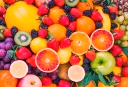

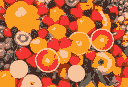

4629.054153449265


In [ ]:
qimg8, cls8 = quantize_image(imgsmall, 8, 10)
cv2_imshow(imgsmall)
cv2_imshow(qimg8)
print(compare_images(imgsmall, qimg8))

We can look at this on the full-sized image too, though this is going to take longer to run (took me around 3 minutes).

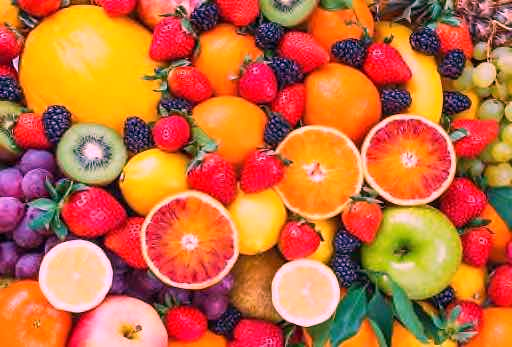

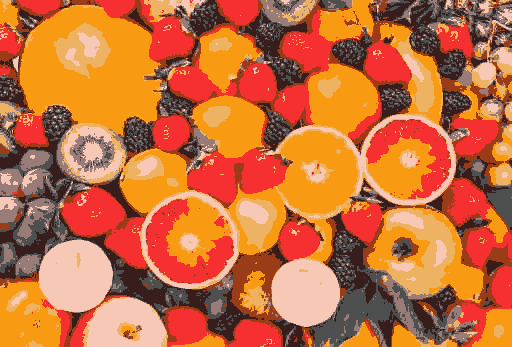

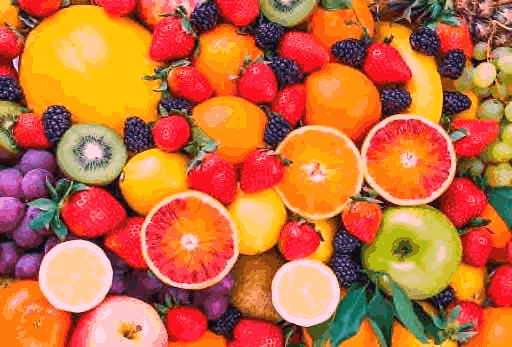

18362.539602982757
7918.883394242653


In [ ]:
qimg8, cls8 = quantize_image(img, 8, 10)
qimg128, cls128 = quantize_image(img, 128, 10)
cv2_imshow(img)
cv2_imshow(qimg8)
cv2_imshow(qimg128)
print(compare_images(img, qimg8))
print(compare_images(img, qimg128))

In [ ]:
def better_quantize_image(img, k, n):
  cls = []
  cls.append(np.random.randint(0,256,3))
  x, y, _ = img.shape
  for _ in range(k - 1):
      dist = np.zeros((x, y))
      for i in range(x):
          for j in range(y):
              px = img[i, j]
              min_dist = float('inf')
              for c in cls:
                  d = np.linalg.norm(px - c)
                  if d < min_dist:
                      min_dist = d
              dist[i, j] = min_dist

      best_i, best_j = 0, 0
      max_dist = float('-inf')

      for i in range(dist.shape[0]):
          for j in range(dist.shape[1]):
              if dist[i, j] > max_dist:
                  max_dist = dist[i, j]
                  best_i, best_j = i, j

      furthest_px = img[best_i, best_j]
      cls.append(furthest_px)

  cls, asgn = initialized_k_means(cls, img, n)
  centers = np.array(cls)
  qimg = centers[asgn.astype(int)]

  return qimg, cls

Here is an example showing our codes performance

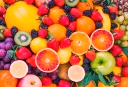

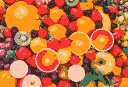

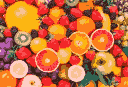

3994.348153775002
3389.232475685795


In [ ]:
qimgsmall1, cls1 = quantize_image(imgsmall, 16, 10)
qimgsmall2, cls2 = better_quantize_image(imgsmall, 16, 10)
cv2_imshow(imgsmall)
cv2_imshow(qimgsmall1)
cv2_imshow(qimgsmall2)
print(compare_images(imgsmall, qimgsmall1))
print(compare_images(imgsmall, qimgsmall2))